# Importing Libraries

In [ ]:
import pandas as pd 
import numpy as np
import scipy
import math
from math import sqrt
import os
import tensorflow as ts
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array 
from collections import Counter
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import math
from collections import Counter
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from nltk.probability import FreqDist
from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loading the Dataset

In [ ]:
import requests

def download_sick(f): 

    response = requests.get(f).text

    lines = response.split("\n")[1:]
    lines = [l.split("\t") for l in lines if len(l) > 0]
    lines = [l for l in lines if len(l) == 5]

    df = pd.DataFrame(lines, columns=["idx", "sent_1", "sent_2", "sim", "label"])
    df['sim'] = pd.to_numeric(df['sim'])
    return df
    
sick_train = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_train.txt")
sick_dev = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_trial.txt")
sick_test = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_test_annotated.txt")
sick_all = sick_train.append(sick_test).append(sick_dev)

In [ ]:
#sick_all[:10]

,idx,sent_1,sent_2,sim,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL
5,12,Two dogs are fighting,Two dogs are wrestling and hugging,4.0,NEUTRAL
6,14,A brown dog is attacking another animal in fro...,Two dogs are fighting,3.5,NEUTRAL
7,18,A brown dog is attacking another animal in fro...,Two dogs are wrestling and hugging,3.2,NEUTRAL
8,25,Nobody is riding the bicycle on one wheel,A person in a black jacket is doing tricks on ...,2.8,NEUTRAL
9,26,A person is riding the bicycle on one wheel,A man in a black jacket is doing tricks on a m...,3.7,NEUTRAL


# Plot for Sentence Pairs and Relatedness

<Figure size 432x288 with 0 Axes>

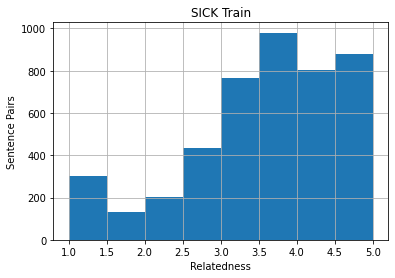

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
sick_train.hist(column="sim", bins=[1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.xlabel("Relatedness")
plt.ylabel("Sentence Pairs")
plt.title('SICK Train')
plt.savefig('sick_train.png')

<Figure size 432x288 with 0 Axes>

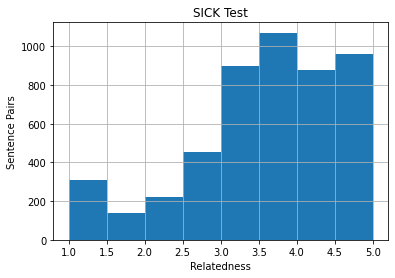

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
sick_test.hist(column="sim", bins=[1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.xlabel("Relatedness")
plt.ylabel("Sentence Pairs")
plt.title('SICK Test')
plt.savefig('sick_test.png')

# Statistical Info 

In [ ]:
sick_train.describe()

,sim
count,4500.000000
mean,3.520946
std,1.025235
min,1.000000
25%,3.000000
50%,3.692500
75%,4.300000
max,5.000000


# Plot for Probability of Number of Words

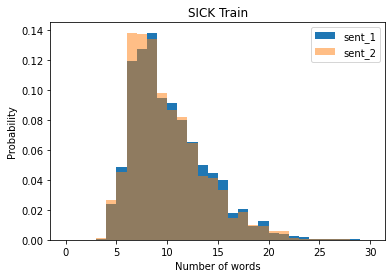

In [ ]:
import pandas as pd

sent_1_qs = pd.Series(sick_train['sent_1'].tolist())
sent_2_qs = pd.Series(sick_train['sent_2'].tolist())

dist_sent_1 = sent_1_qs.apply(lambda x: len(x.split(' ')))
dist_sent_2 = sent_2_qs.apply(lambda x: len(x.split(' ')))

plt.figure()
plt.hist(dist_sent_1, bins=30, range=[0, 30], density=True, label='sent_1')
plt.hist(dist_sent_2, bins=30, range=[0, 30], density=True, alpha=0.5, label='sent_2')
plt.title('SICK Train')
plt.legend()
plt.xlabel('Number of words')
plt.ylabel('Probability')
plt.savefig('sick_train_words.png')

In [ ]:
print('mean-sent_1 {:.2f} std-sent_1 {:.2f} mean-sent_2 {:.2f} std-sent_2 {:.2f} max-sent_1 {:.2f} max-sent_2 {:.2f} min-sent_1 {:.2f} min-sent_2 {:.2f}'.format(dist_sent_1.mean(),
                          dist_sent_1.std(), dist_sent_2.mean(), dist_sent_2.std(), dist_sent_1.max(), dist_sent_2.max(), dist_sent_1.min(), dist_sent_2.min()))

mean-sent_1 9.73 std-sent_1 3.69 mean-sent_2 9.52 std-sent_2 3.65 max-sent_1 28.00 max-sent_2 32.00 min-sent_1 3.00 min-sent_2 3.00


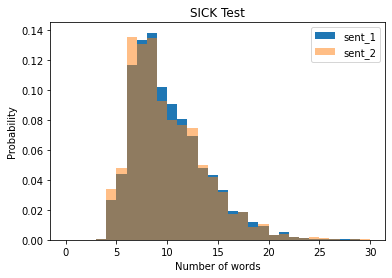

In [ ]:
import pandas as pd

sent_1_qs = pd.Series(sick_test['sent_1'].tolist())
sent_2_qs = pd.Series(sick_test['sent_2'].tolist())

# dist_sent_1 = sent_1_qs.apply(len)
# dist_sent_2 = sent_2_qs.apply(len)

dist_sent_1 = sent_1_qs.apply(lambda x: len(x.split(' ')))
dist_sent_2 = sent_2_qs.apply(lambda x: len(x.split(' ')))

plt.figure()
plt.hist(dist_sent_1, bins=30, range=[0, 30], density=True, label='sent_1')
plt.hist(dist_sent_2, bins=30, range=[0, 30], density=True, alpha=0.5, label='sent_2')
plt.title('SICK Test')
plt.legend()
plt.xlabel('Number of words')
plt.ylabel('Probability')
plt.savefig('sick_test_words.png')

# General Statistics on Sentences contained in Dataframe

In [ ]:
print('mean-sent_1 {:.2f} std-sent_1 {:.2f} mean-sent_2 {:.2f} std-sent_2 {:.2f} max-sent_1 {:.2f} max-sent_2 {:.2f} min-sent_1 {:.2f} min-sent_2 {:.2f}'.format(dist_sent_1.mean(),
                          dist_sent_1.std(), dist_sent_2.mean(), dist_sent_2.std(), dist_sent_1.max(), dist_sent_2.max(), dist_sent_1.min(), dist_sent_2.min()))

mean-sent_1 9.69 std-sent_1 3.66 mean-sent_2 9.53 std-sent_2 3.70 max-sent_1 28.00 max-sent_2 30.00 min-sent_1 3.00 min-sent_2 3.00


# Plot on Word share and relatedness 

In [ ]:
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['sent_1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['sent_2'].split(" ")))
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [ ]:
def transform(x):
    if x<=2:
        return "1-2"
    elif 2<x<=3:
        return "2-3"
    elif 3<x<=4:
        return "3-4"
    elif 4<x<=5:
        return "4-5"

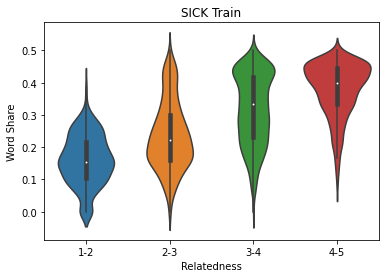

In [ ]:

sick_train.sort_values('sim')

sick_train['sim_bucket'] = sick_train.apply(lambda x: transform(x['sim']), axis=1)
sick_train['word_share'] = sick_train.apply(normalized_word_share, axis=1)

sick_train.head()
plt.figure()
sns.violinplot(x = sick_train['sim_bucket'], y = sick_train['word_share'], order=["1-2", "2-3", "3-4", "4-5"])
plt.xlabel("Relatedness")
plt.ylabel("Word Share")
plt.title('SICK Train')
plt.savefig('sick_train_word_share.png')

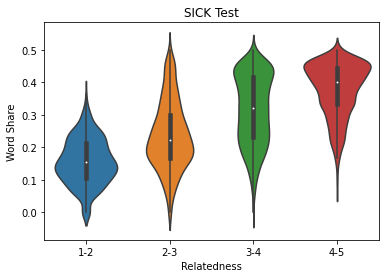

In [ ]:
import seaborn as sns

sick_test.sort_values('sim')

sick_test['sim_bucket'] = sick_test.apply(lambda x: transform(x['sim']), axis=1)
sick_test['word_share'] = sick_test.apply(normalized_word_share, axis=1)

sick_test.head()
plt.figure()
sns.violinplot(x = sick_test['sim_bucket'], y = sick_test['word_share'], order=["1-2", "2-3", "3-4", "4-5"])
plt.xlabel("Relatedness")
plt.ylabel("Word Share")
plt.title('SICK Test')
plt.savefig('sick_test_word_share.png')

# Word Cloud 

In [ ]:
df1 = sick_train['sent_1'].values
df1

array(['A group of kids is playing in a yard and an old man is standing in the background',
       'A group of children is playing in the house and there is no man standing in the background',
       'The young boys are playing outdoors and the man is smiling nearby',
       ..., 'The man is singing heartily and playing the guitar',
       'A man in blue has a yellow ball in the mitt',
       'Three dogs are resting on a sidewalk'], dtype=object)

In [ ]:
df2 = sick_train['sent_2'].values
len(df2)

4500

In [ ]:
# import numpy as np
# df = np.concatenate((df1,df2), axis=0)
# df

In [ ]:
d1_string = ''
for i in range(len(df1)):
  s1 = df1[i]
  d1_string += ' '+(s1) 

In [ ]:
d1_string

" A group of kids is playing in a yard and an old man is standing in the background A group of children is playing in the house and there is no man standing in the background The young boys are playing outdoors and the man is smiling nearby The kids are playing outdoors near a man with a smile The young boys are playing outdoors and the man is smiling nearby Two dogs are fighting A brown dog is attacking another animal in front of the man in pants A brown dog is attacking another animal in front of the man in pants Nobody is riding the bicycle on one wheel A person is riding the bicycle on one wheel A person on a black motorbike is doing tricks with a jacket A man with a jersey is dunking the ball at a basketball game A man with a jersey is dunking the ball at a basketball game The player is dunking the basketball into the net and a crowd is in background Two people are kickboxing and spectators are not watching Two young women are sparring in a kickboxing fight Two young women are not

In [ ]:
from wordcloud import WordCloud

# Word Cloud on Sentences 1 

In [ ]:
cloud = WordCloud(background_color="white").generate(d1_string)

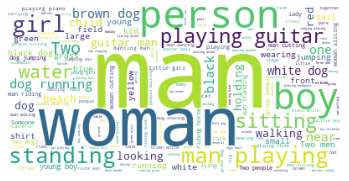

In [ ]:
plt.imshow(cloud)
plt.axis('off')
plt.show()

# Word Cloud on Sentences 2

In [ ]:
d2_string = ''
for i in range(len(df2)):
  s2 = df2[i]
  d2_string += ' '+(s2) 

In [ ]:
d2_string

" A group of boys in a yard is playing and a man is standing in the background A group of kids is playing in a yard and an old man is standing in the background The kids are playing outdoors near a man with a smile A group of kids is playing in a yard and an old man is standing in the background A group of kids is playing in a yard and an old man is standing in the background Two dogs are wrestling and hugging Two dogs are fighting Two dogs are wrestling and hugging A person in a black jacket is doing tricks on a motorbike A man in a black jacket is doing tricks on a motorbike A person is riding the bicycle on one wheel The ball is being dunked by a man with a jersey at a basketball game A man who is playing dunks the basketball into the net and a crowd is in background A man with a jersey is dunking the ball at a basketball game Two people are kickboxing and spectators are watching Two women are sparring in a kickboxing match Two women are sparring in a kickboxing match Two young wome

In [ ]:
cloud = WordCloud(background_color="white").generate(d2_string)

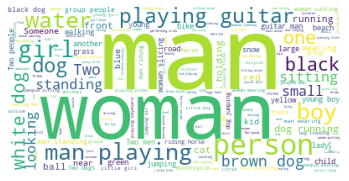

In [ ]:
plt.imshow(cloud)
plt.axis('off')
plt.show()